In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

# Read the data

In [3]:
dfXtrain = pd.read_csv('preprocessed_csv/train.csv', index_col='id')
dfXtest = pd.read_csv('preprocessed_csv/test.csv', index_col='id')
dfYtrain = pd.read_csv('preprocessed_csv/y_train.csv', header=None, names=['INDEX', 'P_TARGET_FLAG'])

In [4]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

y_train = np.array(dfYtrain['P_TARGET_FLAG'])

# Save routines

In [5]:
dfYtest = pd.DataFrame({'INDEX': dfXtest.index, 'P_TARGET_FLAG': np.zeros(x_test.shape[0])})
dfYtest.head()

,INDEX,P_TARGET_FLAG
0,3,0.0
1,9,0.0
2,10,0.0
3,18,0.0
4,21,0.0


In [6]:
def save_to_file(y, file_name):
    dfYtest['P_TARGET_FLAG'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False)

# Train RF

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

In [8]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [9]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict_proba(X)[:, 1]
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, rf_prediction))
    return score

In [11]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, scorer, prefix, print_train=True):
    clf.fit(X_train, y_train)
    if print_train:
        train_score = get_score_list(X_train, y_train, clf, scorer)
    test_score = get_score_list(X_test, y_test, clf, scorer)
    if print_train:
        plt.plot(train_score, label=prefix + ' train set error')
    plt.plot(test_score, label=prefix + ' test set error')
    plt.xlabel('n_estimators')
    plt.ylabel('score')
    plt.legend()
    return test_score, clf

CPU times: user 1min 42s, sys: 8.95 s, total: 1min 51s
Wall time: 59.4 s


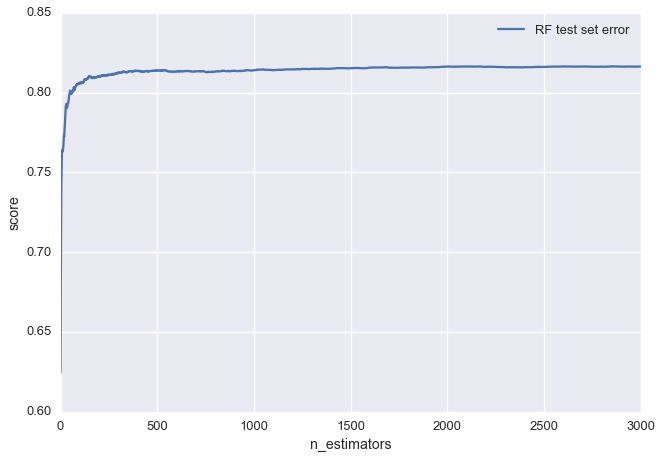

In [12]:
%%time

n_estimators = 3000
test_score, clf = plot_score_graph(RFC(n_estimators=n_estimators, criterion='entropy', n_jobs=-1, random_state=42),
                                   x_subtrain, x_subtest, y_subtrain, y_subtest, roc_auc_score,
                                   prefix='RF', print_train=False)

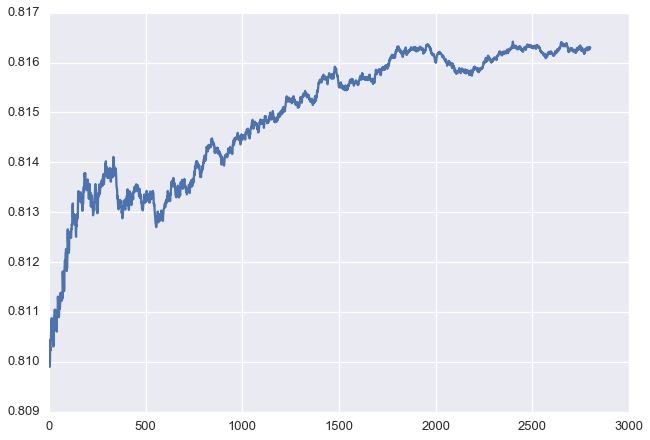

In [13]:
plt.plot(test_score[200:])

In [14]:
rfc = RFC(n_estimators=3000, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(x_train, y_train)
proba = rfc.predict_proba(x_test)[:, 1]
save_to_file(proba, 'simple3000.csv')

In [18]:
def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [19]:
%%time

rfc2 = RFC(n_estimators=3000, criterion='entropy', n_jobs=-1, random_state=100)
rfc2.fit(x_train, y_train)

NameError: name 'combine_rfc' is not defined

In [20]:
rfc6000 = combine_rfs(rfc, rfc2)

proba = rfc6000.predict_proba(x_test)[:, 1]
save_to_file(proba, 'simple6000.csv')

In [21]:
gc.collect()

155